# Data Science Using Snowpark for Python and Auto Arima

The purpose of this script is to demonstrate simple data science predictions on Snowflake objects using Snowpark for Python and Auto Arima. The intent is to begin with a Snowflake table containing monthly website sales data spanning multiple categories and create a predictive model to approximate future sales.

## Import the various packages

Before we can begin, we must import the required packages.

### Main packages

In [1]:
import pandas
import pmdarima
import snowflake.snowpark
from snowflake.snowpark.functions import col

### InterWorks Snowpark package

We must also import the required package from the InterWorks Snowpark package and leverage it to create a Snowflake Snowpark Session object that is connected to our Snowflake environment. Alternatively, you can modify the code to establish a Snowflake Snowpark Session through any method of your choice.

In [2]:
## Import module to build snowpark sessions
from interworks_snowpark.snowpark_session_builder import build_snowpark_session_via_parameters_json as build_snowpark_session

## Generate Snowpark session
snowpark_session = build_snowpark_session()

## Retrieve data

Before we can train a model, we must retrieve the data that we wish to leverage.

### Create variables that will be fed into the stored procedure

By creating variables now, we can more easily convert our process to a Stored Procedure later.

In [3]:
origin_table = 'WEBSITE_SALES'
destination_table = 'WEBSITE_SALES_PREDICTIONS'

### Retrieve the data from the source table

In [ ]:
df_sales_sf1 = snowpark_session.table(f'"SALES_DB"."CLEAN"."{origin_table}"') 

df_sales_sf1.show()

In [6]:
# Use different data set from product sales
df_sales_sf = snowpark_session.sql(f'select SALE_DATE AS MONTH_OF_OPERATION, SALES, CATEGORY from "SALES_DB"."RAW"."PRODUCT_SALES"') 
df_sales_sf.filter( col("CATEGORY") == "ENTERPRISE")
df_sales_sf.show()

-----------------------------------------------------
|"MONTH_OF_OPERATION"  |"SALES"       |"CATEGORY"   |
-----------------------------------------------------
|1995-01-01            |1443.0000000  |PRO EDITION  |
|1995-02-01            |1401.0000000  |PRO EDITION  |
|1995-03-01            |1395.0000000  |PRO EDITION  |
|1995-04-01            |1452.7500000  |PRO EDITION  |
|1995-05-01            |1500.2500000  |PRO EDITION  |
|1995-06-01            |1563.5000000  |PRO EDITION  |
|1995-07-01            |1639.7500000  |PRO EDITION  |
|1995-08-01            |1692.5000000  |PRO EDITION  |
|1995-09-01            |1683.7500000  |PRO EDITION  |
|1995-10-01            |1701.5000000  |PRO EDITION  |
-----------------------------------------------------



### Convert data into a Pandas dataframe

Our current dataframe is a Snowflake dataframe, representing a query to an object in Snowflake. We wish to download this into a Pandas dataframe so that we can manipulate it more freely.

In [7]:
df_sales = pandas.DataFrame(data=df_sales_sf.filter((col("MONTH_OF_OPERATION")>'1995-12-01')).collect()) \
  .sort_values(by=['MONTH_OF_OPERATION',"CATEGORY" ], ignore_index=True) 

display(df_sales)

,MONTH_OF_OPERATION,SALES,CATEGORY
0,1996-01-01,1614.0000000,ENTERPRISE
1,1996-01-01,1845.0000000,PRO EDITION
2,1996-02-01,1529.0000000,ENTERPRISE
3,1996-02-01,1804.7500000,PRO EDITION
4,1996-03-01,1678.0000000,ENTERPRISE
...,...,...,...
619,2021-10-01,4535.7500000,PRO EDITION
620,2021-11-01,5130.0000000,ENTERPRISE
621,2021-11-01,4659.0000000,PRO EDITION
622,2021-12-01,6370.0000000,ENTERPRISE


## Create predictive model

Now that we have our data, we are ready to begin constructing our predictive model.

### Test and Train

Split our data into train and test, based on a predictive horizon of 2 years

In [8]:
pred_periods = 24
split_number = df_sales['SALES'].count() - pred_periods # corresponds to a prediction horizon of 2 years
df_train     = pandas.DataFrame(df_sales['SALES'][:split_number]).rename(columns={'SALES':'y_train'})
df_test      = pandas.DataFrame(df_sales['SALES'][split_number:]).rename(columns={'SALES':'y_test' })

### Create Auto Arima model

Leverage Auto Arima to create a model fit.

In [9]:
model_fit = pmdarima.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9836.529, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8986.691, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9384.067, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11300.648, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9093.525, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8768.243, Time=0.55 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=9071.748, Time=0.20 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7735.786, Time=2.03 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=7694.347, Time=2.11 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=8233.124, Time=1.39 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(1,0,0)(2,0,3)[12] intercept   :

### Summarise model

If desired, the model can be summaries.

In [10]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  600
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -3617.170
Date:                            Wed, 07 Sep 2022   AIC                           7246.340
Time:                                    17:08:29   BIC                           7272.721
Sample:                                         0   HQIC                          7256.609
                                            - 600                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   9.69e-06   1.03e+05      0.000       1.000       1.000
ma.L1         -0.7271      0.025   

### Generate in-sample predictions

The parameter `dynamic=False` means that the model makes predictions upon the lagged values. This means that the model is trained until a point in the time-series and then tries to predict the next value.

In [11]:
# Create the predictions
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pred
df_train['y_train'] = pandas.to_numeric(df_train['y_train'])

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100
#df_train

,y_train,y_train_pred,diff_percent
0,1614.00,0.000000,100.000000
1,1845.00,1613.996653,12.520507
2,1529.00,1735.124213,13.480982
3,1804.75,1655.707356,8.258354
4,1678.00,1704.565508,1.583165
...,...,...,...
595,4260.25,4433.657354,4.070356
596,4846.00,4752.186639,1.935893
597,4331.00,4279.686550,1.184795
598,6241.00,6131.350029,1.756930


### Generate predictions on test data

Generate prediction for n periods. Predictions start from the last date of the training data

In [97]:
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_test['y_test'] = pandas.to_numeric(df_test['y_test'])
#df_test

### Review in-sample test and errors
Review some predictions from the training data. 

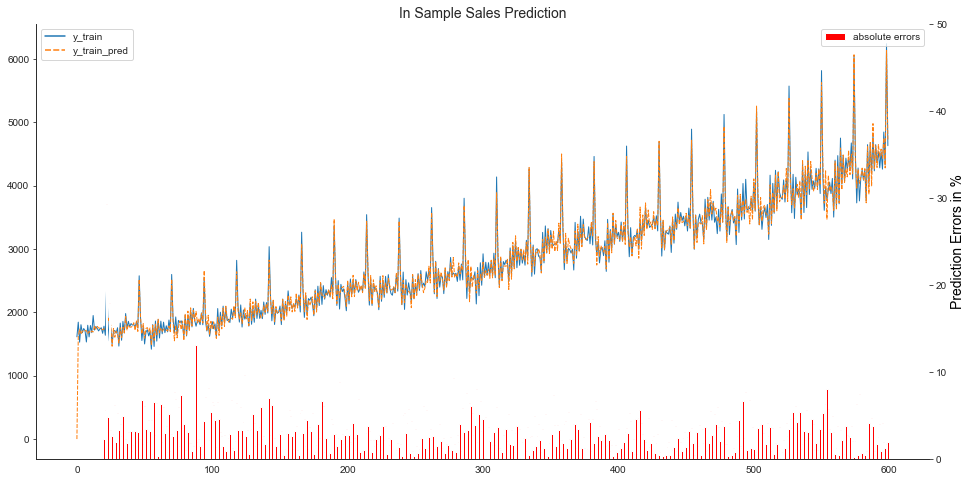

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Generate in-sample Predictions
# The parameter dynamic=False means that the model makes predictions upon the lagged values.
# This means that the model is trained until a point in the time-series and then tries to predict the next value.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pred

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
sns.lineplot(data=df_train[['y_train', 'y_train_pred']], linewidth=1.0)

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='black', fontsize=14)  
ax2.set_ylim([0,50])
ax2.bar(height=df_train['diff_percent'][20:], x=df_train.index[20:], width=1, color='red', label='absolute errors')
plt.legend(['Error %'], loc='upper right')
plt.legend()
plt.show()

### Combine test and train prediction values with original

In [103]:
df_union = pandas.concat([df_sales, df_train, df_test], axis = 1) \
  .rename(columns={'y_train_pred':'TRAIN_PREDICTION', 'y_test_pred': 'TEST_PREDICTION'}) \
  [["MONTH_OF_OPERATION", "CATEGORY", "SALES", "TRAIN_PREDICTION", "TEST_PREDICTION"]]
 
display(df_union)

,MONTH_OF_OPERATION,CATEGORY,SALES,TRAIN_PREDICTION,TEST_PREDICTION
0,1996-01-01,ENTERPRISE,1614.0000000,0.000000,NaN
1,1996-01-01,PRO EDITION,1845.0000000,1613.996653,NaN
2,1996-02-01,ENTERPRISE,1529.0000000,1735.124213,NaN
3,1996-02-01,PRO EDITION,1804.7500000,1655.707356,NaN
4,1996-03-01,ENTERPRISE,1678.0000000,1704.565508,NaN
...,...,...,...,...,...
619,2021-10-01,PRO EDITION,4535.7500000,NaN,4398.204561
620,2021-11-01,ENTERPRISE,5130.0000000,NaN,4951.041502
621,2021-11-01,PRO EDITION,4659.0000000,NaN,4462.008032
622,2021-12-01,ENTERPRISE,6370.0000000,NaN,6298.079572


In [104]:
# cast the data to a datetime
df_union['MONTH_OF_OPERATION'] = pandas.to_datetime(df_union['MONTH_OF_OPERATION']).dt.tz_localize('UTC')
df_union['SALES'] = pandas.to_numeric(df_union['SALES'])
print('----- Structure of the dataframe -----')
df_union.info()
print('\r\n-----  Sample of the dataframe   -----')
df_union

----- Structure of the dataframe -----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   MONTH_OF_OPERATION  624 non-null    datetime64[ns, UTC]
 1   CATEGORY            624 non-null    object             
 2   SALES               624 non-null    float64            
 3   TRAIN_PREDICTION    600 non-null    float64            
 4   TEST_PREDICTION     24 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(1)
memory usage: 29.2+ KB

-----  Sample of the dataframe   -----


,MONTH_OF_OPERATION,CATEGORY,SALES,TRAIN_PREDICTION,TEST_PREDICTION
0,1996-01-01 00:00:00+00:00,ENTERPRISE,1614.00,0.000000,NaN
1,1996-01-01 00:00:00+00:00,PRO EDITION,1845.00,1613.996653,NaN
2,1996-02-01 00:00:00+00:00,ENTERPRISE,1529.00,1735.124213,NaN
3,1996-02-01 00:00:00+00:00,PRO EDITION,1804.75,1655.707356,NaN
4,1996-03-01 00:00:00+00:00,ENTERPRISE,1678.00,1704.565508,NaN
...,...,...,...,...,...
619,2021-10-01 00:00:00+00:00,PRO EDITION,4535.75,NaN,4398.204561
620,2021-11-01 00:00:00+00:00,ENTERPRISE,5130.00,NaN,4951.041502
621,2021-11-01 00:00:00+00:00,PRO EDITION,4659.00,NaN,4462.008032
622,2021-12-01 00:00:00+00:00,ENTERPRISE,6370.00,NaN,6298.079572


### Write output back to Snowflake

Upload the data into the Snowflake table.

In [81]:
snowpark_session.write_pandas(
    df = df_union
  , table_name = destination_table
  , schema = 'MART'
  , database = 'SALES_DB'
  , auto_create_table = True
)

### Compare our predictions with the hold-out test set
We can see the 
* The data used for training (blue)
* The hold-out / test set (orange)
* Actual predictions (green)

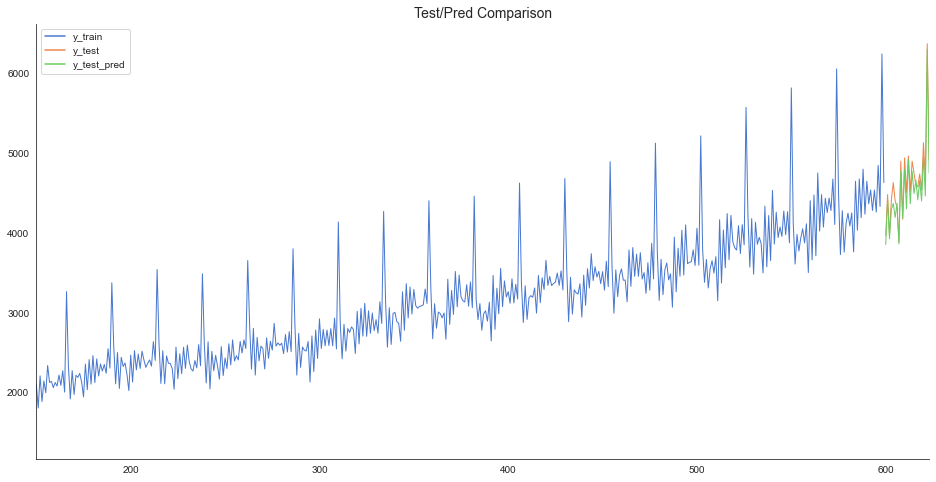

In [96]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_union = pandas.concat([df_train, df_test])

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted') # removed y_train_predict
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()

## Create Snowflake Stored Procedure

Now that we have run through the above in steps, we can combine it all into a function and convert it into a stored procedure.

### Create function

The first part of creating a Stored Procedure to deploy to Snowflake is to create the function that will become the Stored Procedure.

In [ ]:
def generate_auto_arima_predictions(
    snowpark_session: snowflake.snowpark.Session
  , origin_table: str
  , destination_table: str
) :
  # Retrieve the data from the source table
  df_sales_sf = snowpark_session.table(f'"SALES_DB"."CLEAN"."{origin_table}"')

  # Convert data into a Pandas dataframe
  df_sales = pandas.DataFrame(data=df_sales_sf.collect()) \
    .sort_values(by=['MONTH_OF_OPERATION', 'CATEGORY'], ignore_index=True)

  # Test and train
  pred_periods = 24
  split_number = df_sales['SALES'].count() - pred_periods # corresponds to a prediction horizon of 2 years
  df_train     = pandas.DataFrame(df_sales['SALES'][:split_number]).rename(columns={'SALES':'y_train'})
  df_test      = pandas.DataFrame(df_sales['SALES'][split_number:]).rename(columns={'SALES':'y_test' })

  # Create Auto Arima model
  model_fit = pmdarima.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

  # Generate in-sample predictions
  pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
  df_train['y_train_pred'] = pred

  # Generate predictions on test data
  test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
  df_test['y_test_pred'] = test_pred

  # Combine test and train prediction values with original
  df_union = pandas.concat([df_sales, df_train, df_test], axis = 1) \
    .rename(columns={'y_train_pred':'TRAIN_PREDICTION', 'y_test_pred': 'TEST_PREDICTION'}) \
    [["MONTH_OF_OPERATION", "CATEGORY", "SALES", "TRAIN_PREDICTION", "TEST_PREDICTION"]]
  
  # Write output back to Snowflake
  snowpark_session.write_pandas(
      df = df_union
    , table_name = destination_table
    , schema = 'MART'
    , database = 'SALES_DB'
    , auto_create_table = True
  )

  return 'Complete'

### Import any required Snowpark objects

Our stored procedure only requires the data type `StringType` as all inputs and outputs are strings. We must also import the function to create stored procedures.

In [ ]:
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.types import StringType

### Convert function into Stored Procedure

In [ ]:
# Add required packages into the session creating our stored procedure 
snowpark_session.add_packages('snowflake-snowpark-python', 'pandas', 'pmdarima')

# Upload SProc to Snowflake
snowpark_session.sproc.register(
    func = generate_auto_arima_predictions
  , return_type = StringType()
  , input_types = [StringType(), StringType()]
  , is_permanent = True
  , name = 'SALES_DB.PROCEDURES.GENERATE_AUTO_ARIMA_FUNCTION'
  , replace = True
  , stage_location = '@SALES_DB.PROCEDURES.MY_STAGE'
)